# Random-based Explainability in Turkish Text Classification

## Imports and Parameters

In [1]:
%load_ext autoreload
%autoreload 2

from itables import init_notebook_mode
init_notebook_mode(all_interactive=False)
from itables import show
import itables.options as opt
opt.style = "table-layout:auto; width:50%; margin-right:auto; margin-left:0;"
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', 100)
# pd.reset_option('display.max_colwidth')
import pickle
from tqdm.notebook import tqdm

import torch
import warnings
warnings.filterwarnings("ignore", message=".*The 'nopython' keyword.*")

import sys
sys.path.append("Helper_Functions/") 
from general_utils import *
from rand_exp_utils import apply_random
from load_models import prepare_models

<IPython.core.display.Javascript object>

In [2]:
path_config = "Config/config.json"
config = load_hyperparameters(path_config)

path_ttc4900 = config["path_ttc4900"]
path_tr_news = config["path_tr_news"]
path_interpress = config["path_interpress"]
path_tc32 = config["path_tc32"]

path_bert_model_ttc4900 = config["path_bert_model_ttc4900"]
path_bert_model_tr_news = config["path_bert_model_tr_news"] 
path_bert_model_interpress = config["path_bert_model_interpress"]
path_bert_model_tc32 = config["path_bert_model_tc32"]

path_tbt_model_ttc4900 = config["path_tbt_model_ttc4900"]
path_tbt_model_tr_news = config["path_tbt_model_tr_news"] 
path_tbt_model_interpress = config["path_tbt_model_interpress"]
path_tbt_model_tc32 = config["path_tbt_model_tc32"]

path_rand = config["path_rand"]
thresholds = config["thresholds"]
only_load = config["only_load"]

path_reports = config["path_reports"]

pipeline_parameters = config["pipeline_parameters"]
device = torch.device(config["device"]) if torch.cuda.is_available() else torch.device("cpu")

display(pd.DataFrame(list(config.items()), columns=['Parameter', 'Value']))

,Parameter,Value
0,path_ttc4900,Data/TTC_4900/
1,path_tr_news,Data/TR_News/
2,path_interpress,Data/Interpress/
3,path_tc32,Data/TC32/
4,path_bert_model_ttc4900,Models/bertturk_text_classification_fine_tuned_ttc4900
5,path_bert_model_tr_news,Models/bertturk_text_classification_fine_tuned_tr_news
6,path_bert_model_interpress,Models/bertturk_text_classification_fine_tuned_interpress
7,path_bert_model_tc32,Models/bertturk_text_classification_fine_tuned_tc32
8,path_tbt_model_ttc4900,Models/turkishbertweet_text_classification_fine_tuned_ttc4900
9,path_tbt_model_tr_news,Models/turkishbertweet_text_classification_fine_tuned_tr_news


## Load Datasets

In [3]:
from load_datasets import prepare_datasets

ttc4900_test, tr_news_test, interpress_test, tc32_test = prepare_datasets(path_ttc4900, path_tr_news, path_interpress, path_tc32)

print("TTC 4900 Test Set:\n\n", ttc4900_test)
print("\nTR News Test Set:\n\n", tr_news_test)
print("\nInterpress Test Set:\n\n", interpress_test)
print("\nTC 32 Test Set:\n\n", tc32_test)

TTC 4900 Test Set:

 Dataset({
    features: ['text', 'label'],
    num_rows: 735
})

TR News Test Set:

 Dataset({
    features: ['text', 'label'],
    num_rows: 880
})

Interpress Test Set:

 Dataset({
    features: ['text', 'label'],
    num_rows: 1000
})

TC 32 Test Set:

 Dataset({
    features: ['text', 'label'],
    num_rows: 9600
})


## Random-based Explainability

In [4]:
all_exp_results = pd.DataFrame(columns=["Cl Acc", "ECS FT", "ECS TT", "ORC (+)", "ORC (-)"])

### BERTTurk

#### Inference on Full Text

In [5]:
# Load BERTTurk models

bert_model_ttc4900, \
bert_tokenizer_ttc4900, \
bert_config_ttc4900, \
bert_pipeline_text_ttc4900, \
bert_label2id_ttc4900, \
bert_id2label_ttc4900 = prepare_models(path_bert_model_ttc4900, device)

bert_model_tr_news, \
bert_tokenizer_tr_news, \
bert_config_tr_news, \
bert_pipeline_text_tr_news, \
bert_label2id_tr_news, \
bert_id2label_tr_news = prepare_models(path_bert_model_tr_news, device)

bert_model_interpress, \
bert_tokenizer_interpress, \
bert_config_interpress, \
bert_pipeline_text_interpress, \
bert_label2id_interpress, \
bert_id2label_interpress = prepare_models(path_bert_model_interpress, device)

bert_model_tc32, \
bert_tokenizer_tc32, \
bert_config_tc32, \
bert_pipeline_text_tc32, \
bert_label2id_tc32, \
bert_id2label_tc32 = prepare_models(path_bert_model_tc32, device)

Error caught was: No module named 'triton'



'bertturk_text_classification_fine_tuned_ttc4900' is loaded.

'bertturk_text_classification_fine_tuned_tr_news' is loaded.

'bertturk_text_classification_fine_tuned_interpress' is loaded.

'bertturk_text_classification_fine_tuned_tc32' is loaded.


In [6]:
path_classification_results = "Data/Classification_Results/BERTTurk/"

with open(path_classification_results + 'bert_full_text_preds_ttc4900.pkl', 'rb') as file:
    bert_full_text_preds_ttc4900 = pickle.load(file)

with open(path_classification_results + 'bert_full_text_preds_tr_news.pkl', 'rb') as file:
    bert_full_text_preds_tr_news = pickle.load(file)

with open(path_classification_results + 'bert_full_text_preds_interpress.pkl', 'rb') as file:
    bert_full_text_preds_interpress = pickle.load(file)

with open(path_classification_results + 'bert_full_text_preds_tc32.pkl', 'rb') as file:
    bert_full_text_preds_tc32 = pickle.load(file)

In [7]:
num_samples = 100

ttc4900_test = ttc4900_test.select(range(num_samples))
tr_news_test = tr_news_test.select(range(num_samples))
interpress_test = interpress_test.select(range(num_samples))
tc32_test = tc32_test.select(range(num_samples))

bert_full_text_preds_ttc4900 = bert_full_text_preds_ttc4900[:num_samples]
bert_full_text_preds_tr_news = bert_full_text_preds_tr_news[:num_samples]
bert_full_text_preds_interpress = bert_full_text_preds_interpress[:num_samples]
bert_full_text_preds_tc32 = bert_full_text_preds_tc32[:num_samples]

#### TTC4900

In [30]:
ttc4900_bert_results = {}

# Run the random process 5 times to compute mean and std
for iteration in range(5):
    for threshold in thresholds:
        rand_values_ttc = apply_random(path_rand, ttc4900_test, bert_model_ttc4900, bert_tokenizer_ttc4900, 
                                       f"rand_values_ttc_{threshold}_{iteration}_bert", device, only_load=only_load)
        
        top_tokens_ttc4900 = apply_thresholding(rand_values_ttc, threshold)

        ttc4900_bert_result = compare_probs(ttc4900_test,
                                            bert_full_text_preds_ttc4900,
                                            top_tokens_ttc4900,
                                            None,
                                            bert_model_ttc4900, bert_tokenizer_ttc4900,
                                            id2label=bert_id2label_ttc4900,
                                            device=device)

        # Store the result for aggregation
        if threshold not in ttc4900_bert_results:
            ttc4900_bert_results[threshold] = []
        ttc4900_bert_results[threshold].append(ttc4900_bert_result)

        clear_gpu_memory()

for threshold, dataframes in ttc4900_bert_results.items():

    base_df = dataframes[0].copy()

    # For each run, add the 'Pred Prob - Top Tokens' values as new columns in the base_df
    for i, df in enumerate(dataframes):
        base_df[f'Run {i+1} - Pred Prob - Top Tokens'] = df['Pred Prob - Top Tokens']

    # Calculate mean and std for 'Pred Prob - Top Tokens' across the three runs for each sample
    top_tokens_means = np.mean([df['Pred Prob - Top Tokens'] for df in dataframes], axis=0)
    top_tokens_stds = np.std([df['Pred Prob - Top Tokens'] for df in dataframes], axis=0)

    # Update the base dataframe with the calculated means and stds
    base_df['Mean - Pred Prob - Top Tokens'] = top_tokens_means
    base_df['Std - Pred Prob - Top Tokens'] = top_tokens_stds

    ttc4900_bert_results[threshold] = [base_df]
    
    show(ttc4900_bert_results[threshold][0], lengthMenu=list(range(10, 200, 30)), dom="lti")

  0%|          | 0/100 [00:00<?, ?it/s]

File 'rand_values_ttc_0.5_0_bert' saved.
'rand_values_ttc_0.5_0_bert' file shape: 100


  0%|          | 0/100 [00:00<?, ?it/s]

File 'rand_values_ttc_0.6_0_bert' saved.
'rand_values_ttc_0.6_0_bert' file shape: 100


  0%|          | 0/100 [00:00<?, ?it/s]

File 'rand_values_ttc_0.7_0_bert' saved.
'rand_values_ttc_0.7_0_bert' file shape: 100


  0%|          | 0/100 [00:00<?, ?it/s]

File 'rand_values_ttc_0.5_1_bert' saved.
'rand_values_ttc_0.5_1_bert' file shape: 100


  0%|          | 0/100 [00:00<?, ?it/s]

File 'rand_values_ttc_0.6_1_bert' saved.
'rand_values_ttc_0.6_1_bert' file shape: 100


  0%|          | 0/100 [00:00<?, ?it/s]

File 'rand_values_ttc_0.7_1_bert' saved.
'rand_values_ttc_0.7_1_bert' file shape: 100


  0%|          | 0/100 [00:00<?, ?it/s]

File 'rand_values_ttc_0.5_2_bert' saved.
'rand_values_ttc_0.5_2_bert' file shape: 100


  0%|          | 0/100 [00:00<?, ?it/s]

File 'rand_values_ttc_0.6_2_bert' saved.
'rand_values_ttc_0.6_2_bert' file shape: 100


  0%|          | 0/100 [00:00<?, ?it/s]

File 'rand_values_ttc_0.7_2_bert' saved.
'rand_values_ttc_0.7_2_bert' file shape: 100


  0%|          | 0/100 [00:00<?, ?it/s]

File 'rand_values_ttc_0.5_3_bert' saved.
'rand_values_ttc_0.5_3_bert' file shape: 100


  0%|          | 0/100 [00:00<?, ?it/s]

File 'rand_values_ttc_0.6_3_bert' saved.
'rand_values_ttc_0.6_3_bert' file shape: 100


  0%|          | 0/100 [00:00<?, ?it/s]

File 'rand_values_ttc_0.7_3_bert' saved.
'rand_values_ttc_0.7_3_bert' file shape: 100


  0%|          | 0/100 [00:00<?, ?it/s]

File 'rand_values_ttc_0.5_4_bert' saved.
'rand_values_ttc_0.5_4_bert' file shape: 100


  0%|          | 0/100 [00:00<?, ?it/s]

File 'rand_values_ttc_0.6_4_bert' saved.
'rand_values_ttc_0.6_4_bert' file shape: 100


  0%|          | 0/100 [00:00<?, ?it/s]

File 'rand_values_ttc_0.7_4_bert' saved.
'rand_values_ttc_0.7_4_bert' file shape: 100



Classification accuracy                             :  0.88
Explanations Contribution Score (ECS) of Full Text  :  0.972
Explanations Contribution Score (ECS) of Top Tokens :  0.84
Overall Relative Change (ORC) positive changes      :  1.097 %
Overall Relative Change (ORC) negative changes      : -17.284 %


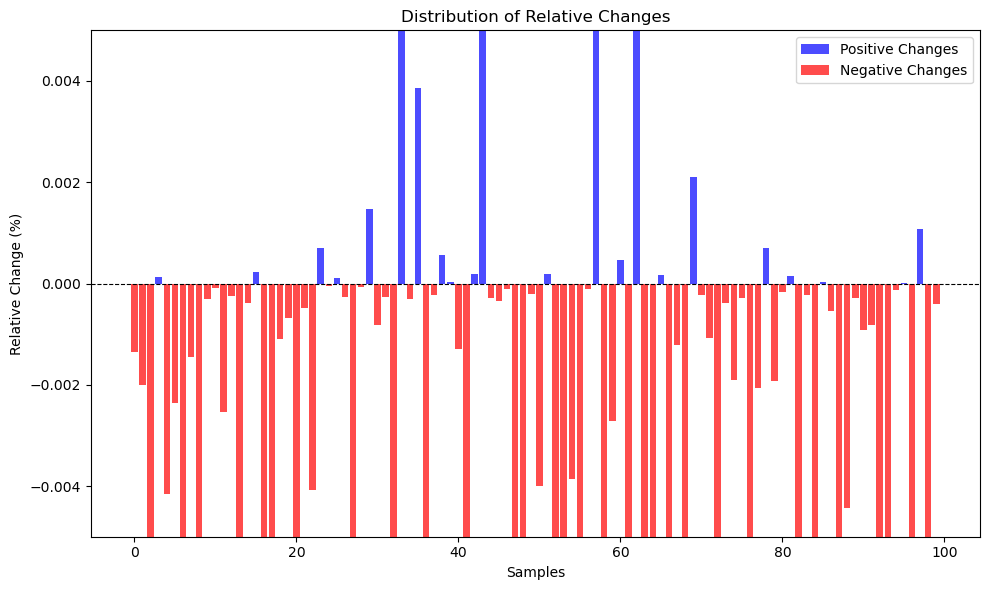


Classification accuracy                             :  0.88
Explanations Contribution Score (ECS) of Full Text  :  0.972
Explanations Contribution Score (ECS) of Top Tokens :  0.86
Overall Relative Change (ORC) positive changes      :  2.509 %
Overall Relative Change (ORC) negative changes      : -14.792 %


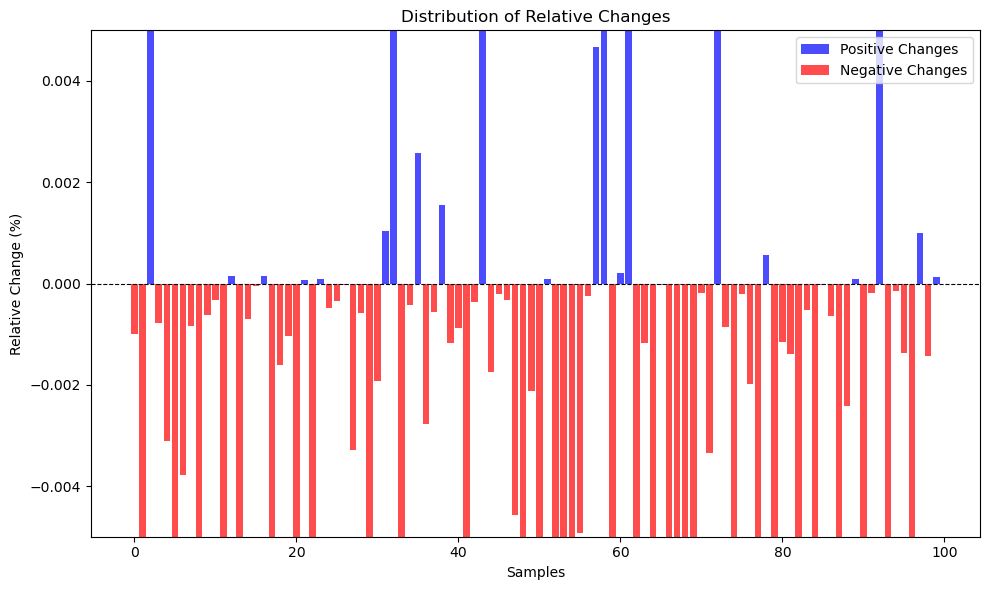


Classification accuracy                             :  0.88
Explanations Contribution Score (ECS) of Full Text  :  0.972
Explanations Contribution Score (ECS) of Top Tokens :  0.818
Overall Relative Change (ORC) positive changes      :  4.767 %
Overall Relative Change (ORC) negative changes      : -19.506 %


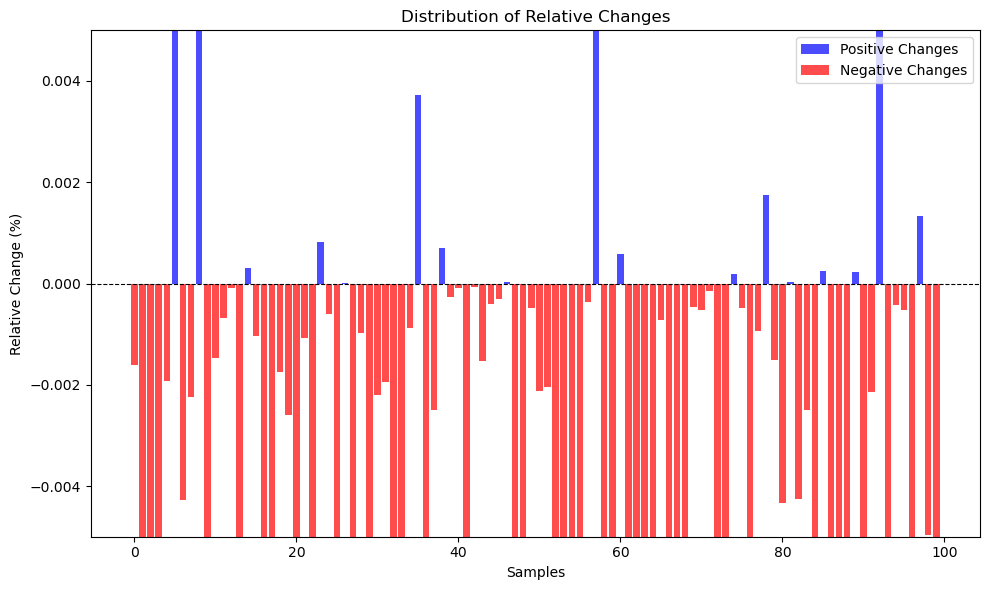

In [36]:
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(ttc4900_bert_results[0.5][0])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(ttc4900_bert_results[0.6][0])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(ttc4900_bert_results[0.7][0])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)

#### TR News

In [37]:
tr_news_bert_results = {}

for iteration in range(5):
    for threshold in thresholds:

        rand_values_tr_news = apply_random(path_rand, tr_news_test, bert_model_tr_news, bert_tokenizer_tr_news, 
                                           f"rand_values_tr_news_{threshold}_{iteration}_bert", device, only_load=only_load)
        
        top_tokens_tr_news = apply_thresholding(rand_values_tr_news, threshold)
    
        tr_news_bert_result = compare_probs(tr_news_test,
                                            bert_full_text_preds_tr_news,
                                            top_tokens_tr_news,
                                            None,
                                            bert_model_tr_news, bert_tokenizer_tr_news,
                                            id2label=bert_id2label_tr_news,
                                            device=device)

        if threshold not in tr_news_bert_results:
            tr_news_bert_results[threshold] = []
        tr_news_bert_results[threshold].append(tr_news_bert_result)
        
        clear_gpu_memory()

for threshold, dataframes in tr_news_bert_results.items():

    base_df = dataframes[0].copy()

    for i, df in enumerate(dataframes):
        base_df[f'Run {i+1} - Pred Prob - Top Tokens'] = df['Pred Prob - Top Tokens']

    top_tokens_means = np.mean([df['Pred Prob - Top Tokens'] for df in dataframes], axis=0)
    top_tokens_stds = np.std([df['Pred Prob - Top Tokens'] for df in dataframes], axis=0)

    base_df['Mean - Pred Prob - Top Tokens'] = top_tokens_means
    base_df['Std - Pred Prob - Top Tokens'] = top_tokens_stds

    tr_news_bert_results[threshold] = [base_df]
    
    show(tr_news_bert_results[threshold][0], lengthMenu=list(range(10, 200, 30)), dom="lti")

  0%|          | 0/100 [00:00<?, ?it/s]

File 'rand_values_tr_news_0.5_0_bert' saved.
'rand_values_tr_news_0.5_0_bert' file shape: 100


  0%|          | 0/100 [00:00<?, ?it/s]

File 'rand_values_tr_news_0.6_0_bert' saved.
'rand_values_tr_news_0.6_0_bert' file shape: 100


  0%|          | 0/100 [00:00<?, ?it/s]

File 'rand_values_tr_news_0.7_0_bert' saved.
'rand_values_tr_news_0.7_0_bert' file shape: 100


  0%|          | 0/100 [00:00<?, ?it/s]

File 'rand_values_tr_news_0.5_1_bert' saved.
'rand_values_tr_news_0.5_1_bert' file shape: 100


  0%|          | 0/100 [00:00<?, ?it/s]

File 'rand_values_tr_news_0.6_1_bert' saved.
'rand_values_tr_news_0.6_1_bert' file shape: 100


  0%|          | 0/100 [00:00<?, ?it/s]

File 'rand_values_tr_news_0.7_1_bert' saved.
'rand_values_tr_news_0.7_1_bert' file shape: 100


  0%|          | 0/100 [00:00<?, ?it/s]

File 'rand_values_tr_news_0.5_2_bert' saved.
'rand_values_tr_news_0.5_2_bert' file shape: 100


  0%|          | 0/100 [00:00<?, ?it/s]

File 'rand_values_tr_news_0.6_2_bert' saved.
'rand_values_tr_news_0.6_2_bert' file shape: 100


  0%|          | 0/100 [00:00<?, ?it/s]

File 'rand_values_tr_news_0.7_2_bert' saved.
'rand_values_tr_news_0.7_2_bert' file shape: 100


  0%|          | 0/100 [00:00<?, ?it/s]

File 'rand_values_tr_news_0.5_3_bert' saved.
'rand_values_tr_news_0.5_3_bert' file shape: 100


  0%|          | 0/100 [00:00<?, ?it/s]

File 'rand_values_tr_news_0.6_3_bert' saved.
'rand_values_tr_news_0.6_3_bert' file shape: 100


  0%|          | 0/100 [00:00<?, ?it/s]

File 'rand_values_tr_news_0.7_3_bert' saved.
'rand_values_tr_news_0.7_3_bert' file shape: 100


  0%|          | 0/100 [00:00<?, ?it/s]

File 'rand_values_tr_news_0.5_4_bert' saved.
'rand_values_tr_news_0.5_4_bert' file shape: 100


  0%|          | 0/100 [00:00<?, ?it/s]

File 'rand_values_tr_news_0.6_4_bert' saved.
'rand_values_tr_news_0.6_4_bert' file shape: 100


  0%|          | 0/100 [00:00<?, ?it/s]

File 'rand_values_tr_news_0.7_4_bert' saved.
'rand_values_tr_news_0.7_4_bert' file shape: 100



Classification accuracy                             :  0.75
Explanations Contribution Score (ECS) of Full Text  :  0.839
Explanations Contribution Score (ECS) of Top Tokens :  0.612
Overall Relative Change (ORC) positive changes      :  6.301 %
Overall Relative Change (ORC) negative changes      : -26.309 %


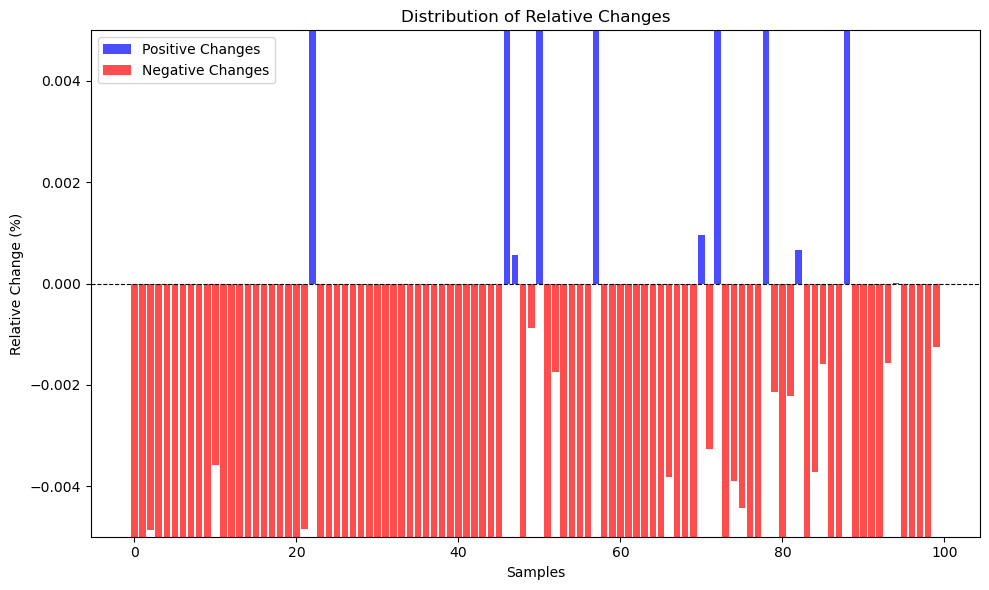


Classification accuracy                             :  0.75
Explanations Contribution Score (ECS) of Full Text  :  0.839
Explanations Contribution Score (ECS) of Top Tokens :  0.597
Overall Relative Change (ORC) positive changes      :  9.189 %
Overall Relative Change (ORC) negative changes      : -28.314 %


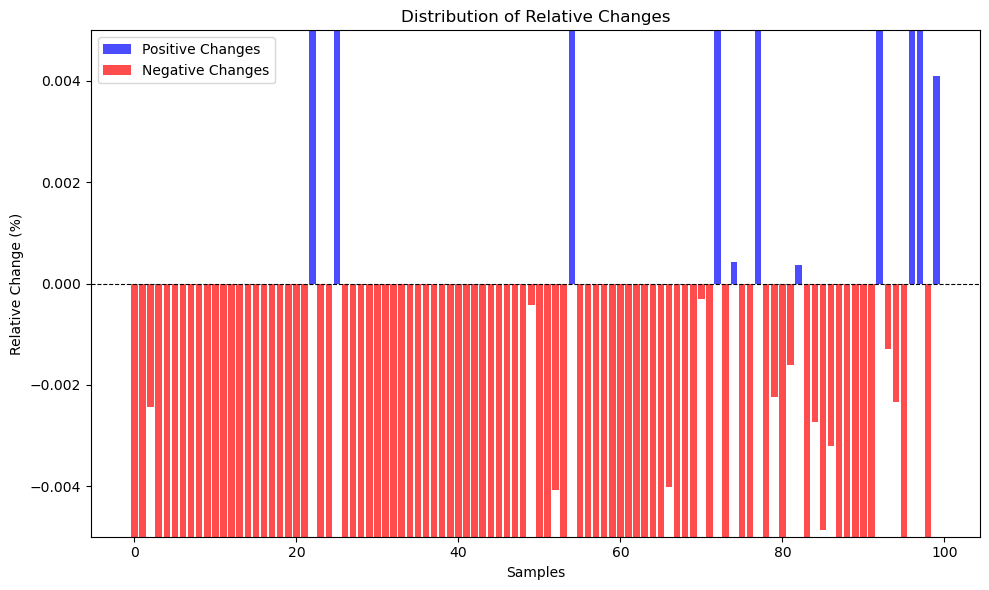


Classification accuracy                             :  0.75
Explanations Contribution Score (ECS) of Full Text  :  0.839
Explanations Contribution Score (ECS) of Top Tokens :  0.556
Overall Relative Change (ORC) positive changes      :  4.756 %
Overall Relative Change (ORC) negative changes      : -34.167 %


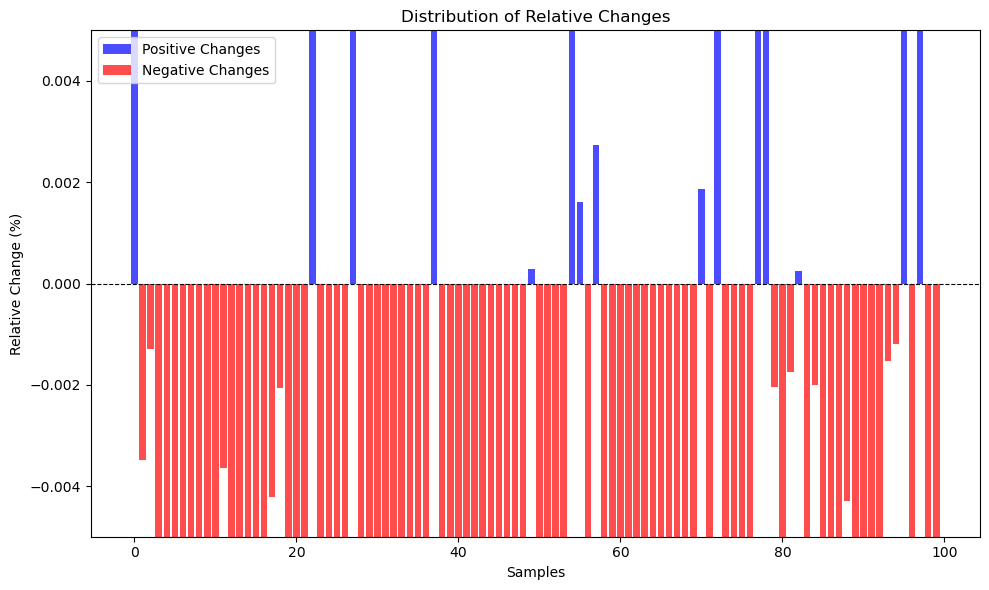

In [38]:
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(tr_news_bert_results[0.5][0])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(tr_news_bert_results[0.6][0])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(tr_news_bert_results[0.7][0])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)

#### Interpress

In [40]:
interpress_bert_results = {}

for iteration in range(5):
    for threshold in thresholds:

        rand_values_interpress = apply_random(path_rand, interpress_test, bert_model_interpress, bert_tokenizer_interpress, 
                                              f"rand_values_interpress_{threshold}_{iteration}_bert", device, only_load=only_load)
        
        top_tokens_interpress = apply_thresholding(rand_values_interpress, threshold)
    
        interpress_bert_result = compare_probs(interpress_test,
                                               bert_full_text_preds_interpress,
                                               top_tokens_interpress,
                                               None,
                                               bert_model_interpress, bert_tokenizer_interpress,
                                               id2label=bert_id2label_interpress,
                                               device=device)

        if threshold not in interpress_bert_results:
            interpress_bert_results[threshold] = []
        interpress_bert_results[threshold].append(interpress_bert_result)
        
        clear_gpu_memory()

for threshold, dataframes in interpress_bert_results.items():

    base_df = dataframes[0].copy()

    for i, df in enumerate(dataframes):
        base_df[f'Run {i+1} - Pred Prob - Top Tokens'] = df['Pred Prob - Top Tokens']

    top_tokens_means = np.mean([df['Pred Prob - Top Tokens'] for df in dataframes], axis=0)
    top_tokens_stds = np.std([df['Pred Prob - Top Tokens'] for df in dataframes], axis=0)

    base_df['Mean - Pred Prob - Top Tokens'] = top_tokens_means
    base_df['Std - Pred Prob - Top Tokens'] = top_tokens_stds

    interpress_bert_results[threshold] = [base_df]
    
    show(interpress_bert_results[threshold][0], lengthMenu=list(range(10, 200, 30)), dom="lti")

  0%|          | 0/100 [00:00<?, ?it/s]

File 'rand_values_interpress_0.5_0_bert' saved.
'rand_values_interpress_0.5_0_bert' file shape: 100


  0%|          | 0/100 [00:00<?, ?it/s]

File 'rand_values_interpress_0.6_0_bert' saved.
'rand_values_interpress_0.6_0_bert' file shape: 100


  0%|          | 0/100 [00:00<?, ?it/s]

File 'rand_values_interpress_0.7_0_bert' saved.
'rand_values_interpress_0.7_0_bert' file shape: 100


  0%|          | 0/100 [00:00<?, ?it/s]

File 'rand_values_interpress_0.5_1_bert' saved.
'rand_values_interpress_0.5_1_bert' file shape: 100


  0%|          | 0/100 [00:00<?, ?it/s]

File 'rand_values_interpress_0.6_1_bert' saved.
'rand_values_interpress_0.6_1_bert' file shape: 100


  0%|          | 0/100 [00:00<?, ?it/s]

File 'rand_values_interpress_0.7_1_bert' saved.
'rand_values_interpress_0.7_1_bert' file shape: 100


  0%|          | 0/100 [00:00<?, ?it/s]

File 'rand_values_interpress_0.5_2_bert' saved.
'rand_values_interpress_0.5_2_bert' file shape: 100


  0%|          | 0/100 [00:00<?, ?it/s]

File 'rand_values_interpress_0.6_2_bert' saved.
'rand_values_interpress_0.6_2_bert' file shape: 100


  0%|          | 0/100 [00:00<?, ?it/s]

File 'rand_values_interpress_0.7_2_bert' saved.
'rand_values_interpress_0.7_2_bert' file shape: 100


  0%|          | 0/100 [00:00<?, ?it/s]

File 'rand_values_interpress_0.5_3_bert' saved.
'rand_values_interpress_0.5_3_bert' file shape: 100


  0%|          | 0/100 [00:00<?, ?it/s]

File 'rand_values_interpress_0.6_3_bert' saved.
'rand_values_interpress_0.6_3_bert' file shape: 100


  0%|          | 0/100 [00:00<?, ?it/s]

File 'rand_values_interpress_0.7_3_bert' saved.
'rand_values_interpress_0.7_3_bert' file shape: 100


  0%|          | 0/100 [00:00<?, ?it/s]

File 'rand_values_interpress_0.5_4_bert' saved.
'rand_values_interpress_0.5_4_bert' file shape: 100


  0%|          | 0/100 [00:00<?, ?it/s]

File 'rand_values_interpress_0.6_4_bert' saved.
'rand_values_interpress_0.6_4_bert' file shape: 100


  0%|          | 0/100 [00:00<?, ?it/s]

File 'rand_values_interpress_0.7_4_bert' saved.
'rand_values_interpress_0.7_4_bert' file shape: 100



Classification accuracy                             :  0.84
Explanations Contribution Score (ECS) of Full Text  :  0.934
Explanations Contribution Score (ECS) of Top Tokens :  0.779
Overall Relative Change (ORC) positive changes      :  2.942 %
Overall Relative Change (ORC) negative changes      : -20.672 %


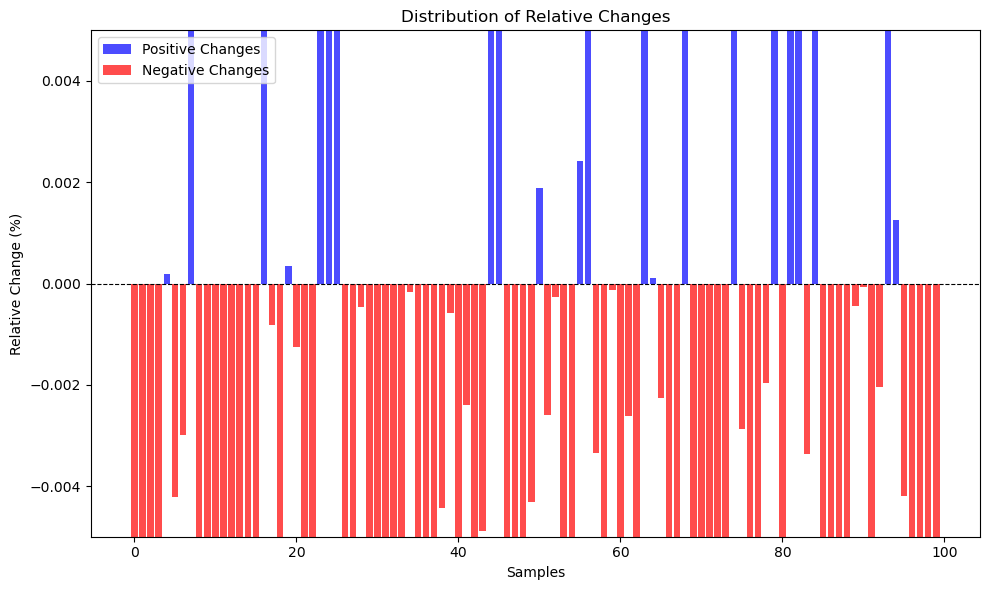


Classification accuracy                             :  0.84
Explanations Contribution Score (ECS) of Full Text  :  0.934
Explanations Contribution Score (ECS) of Top Tokens :  0.717
Overall Relative Change (ORC) positive changes      :  5.195 %
Overall Relative Change (ORC) negative changes      : -27.603 %


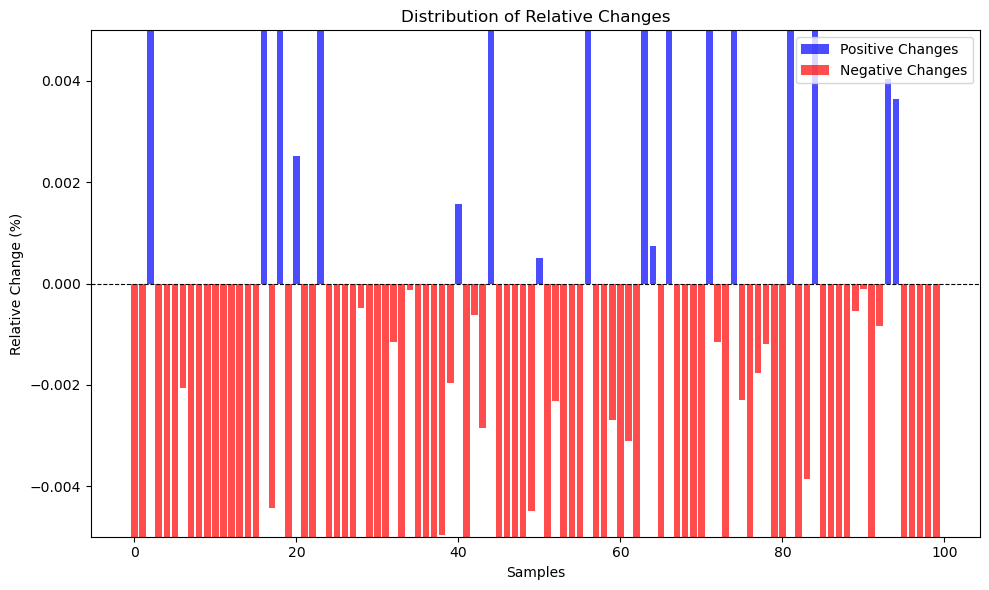


Classification accuracy                             :  0.84
Explanations Contribution Score (ECS) of Full Text  :  0.934
Explanations Contribution Score (ECS) of Top Tokens :  0.741
Overall Relative Change (ORC) positive changes      :  5.018 %
Overall Relative Change (ORC) negative changes      : -25.805 %


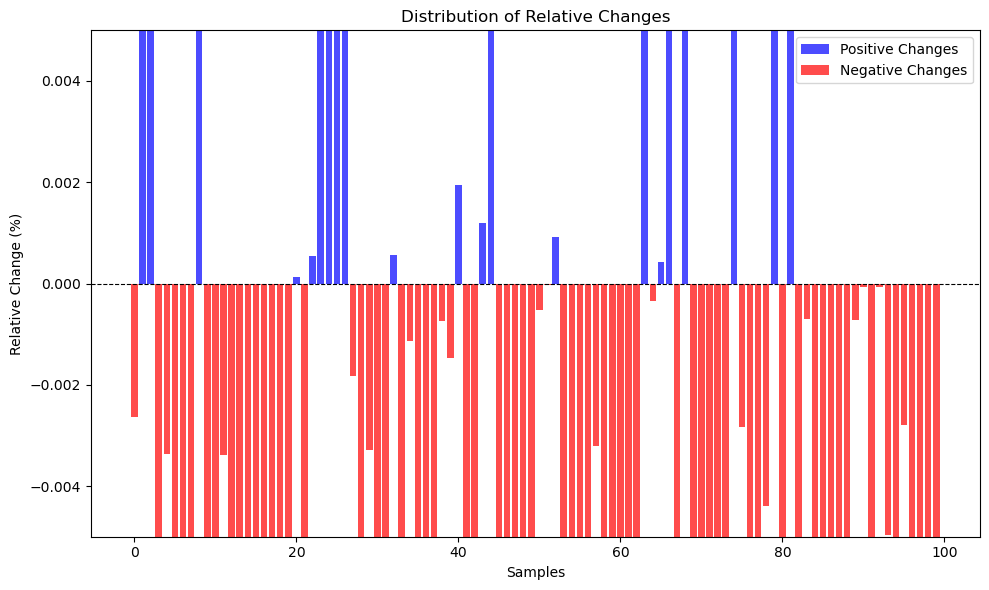

In [41]:
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(interpress_bert_results[0.5][0])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(interpress_bert_results[0.6][0])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(interpress_bert_results[0.7][0])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)

#### TC 32

In [42]:
tc32_bert_results = {}

for iteration in range(5):
    for threshold in thresholds:

        rand_values_tc32 = apply_random(path_rand, tc32_test, bert_model_tc32, bert_tokenizer_tc32, 
                                              f"rand_values_tc32_{threshold}_{iteration}_bert", device, only_load=only_load)
        
        top_tokens_tc32 = apply_thresholding(rand_values_tc32, threshold)
    
        tc32_bert_result = compare_probs(tc32_test,
                                               bert_full_text_preds_tc32,
                                               top_tokens_tc32,
                                               None,
                                               bert_model_tc32, bert_tokenizer_tc32,
                                               id2label=bert_id2label_tc32,
                                               device=device)

        if threshold not in tc32_bert_results:
            tc32_bert_results[threshold] = []
        tc32_bert_results[threshold].append(tc32_bert_result)
        
        clear_gpu_memory()

for threshold, dataframes in tc32_bert_results.items():

    base_df = dataframes[0].copy()

    for i, df in enumerate(dataframes):
        base_df[f'Run {i+1} - Pred Prob - Top Tokens'] = df['Pred Prob - Top Tokens']

    top_tokens_means = np.mean([df['Pred Prob - Top Tokens'] for df in dataframes], axis=0)
    top_tokens_stds = np.std([df['Pred Prob - Top Tokens'] for df in dataframes], axis=0)

    base_df['Mean - Pred Prob - Top Tokens'] = top_tokens_means
    base_df['Std - Pred Prob - Top Tokens'] = top_tokens_stds

    tc32_bert_results[threshold] = [base_df]
    
    show(tc32_bert_results[threshold][0], lengthMenu=list(range(10, 200, 30)), dom="lti")

  0%|          | 0/100 [00:00<?, ?it/s]

File 'rand_values_tc32_0.5_0_bert' saved.
'rand_values_tc32_0.5_0_bert' file shape: 100


  0%|          | 0/100 [00:00<?, ?it/s]

File 'rand_values_tc32_0.6_0_bert' saved.
'rand_values_tc32_0.6_0_bert' file shape: 100


  0%|          | 0/100 [00:00<?, ?it/s]

File 'rand_values_tc32_0.7_0_bert' saved.
'rand_values_tc32_0.7_0_bert' file shape: 100


  0%|          | 0/100 [00:00<?, ?it/s]

File 'rand_values_tc32_0.5_1_bert' saved.
'rand_values_tc32_0.5_1_bert' file shape: 100


  0%|          | 0/100 [00:00<?, ?it/s]

File 'rand_values_tc32_0.6_1_bert' saved.
'rand_values_tc32_0.6_1_bert' file shape: 100


  0%|          | 0/100 [00:00<?, ?it/s]

File 'rand_values_tc32_0.7_1_bert' saved.
'rand_values_tc32_0.7_1_bert' file shape: 100


  0%|          | 0/100 [00:00<?, ?it/s]

File 'rand_values_tc32_0.5_2_bert' saved.
'rand_values_tc32_0.5_2_bert' file shape: 100


  0%|          | 0/100 [00:00<?, ?it/s]

File 'rand_values_tc32_0.6_2_bert' saved.
'rand_values_tc32_0.6_2_bert' file shape: 100


  0%|          | 0/100 [00:00<?, ?it/s]

File 'rand_values_tc32_0.7_2_bert' saved.
'rand_values_tc32_0.7_2_bert' file shape: 100


  0%|          | 0/100 [00:00<?, ?it/s]

File 'rand_values_tc32_0.5_3_bert' saved.
'rand_values_tc32_0.5_3_bert' file shape: 100


  0%|          | 0/100 [00:00<?, ?it/s]

File 'rand_values_tc32_0.6_3_bert' saved.
'rand_values_tc32_0.6_3_bert' file shape: 100


  0%|          | 0/100 [00:00<?, ?it/s]

File 'rand_values_tc32_0.7_3_bert' saved.
'rand_values_tc32_0.7_3_bert' file shape: 100


  0%|          | 0/100 [00:00<?, ?it/s]

File 'rand_values_tc32_0.5_4_bert' saved.
'rand_values_tc32_0.5_4_bert' file shape: 100


  0%|          | 0/100 [00:00<?, ?it/s]

File 'rand_values_tc32_0.6_4_bert' saved.
'rand_values_tc32_0.6_4_bert' file shape: 100


  0%|          | 0/100 [00:00<?, ?it/s]

File 'rand_values_tc32_0.7_4_bert' saved.
'rand_values_tc32_0.7_4_bert' file shape: 100



Classification accuracy                             :  0.95
Explanations Contribution Score (ECS) of Full Text  :  0.993
Explanations Contribution Score (ECS) of Top Tokens :  0.407
Overall Relative Change (ORC) positive changes      :  20.418 %
Overall Relative Change (ORC) negative changes      : -59.381 %


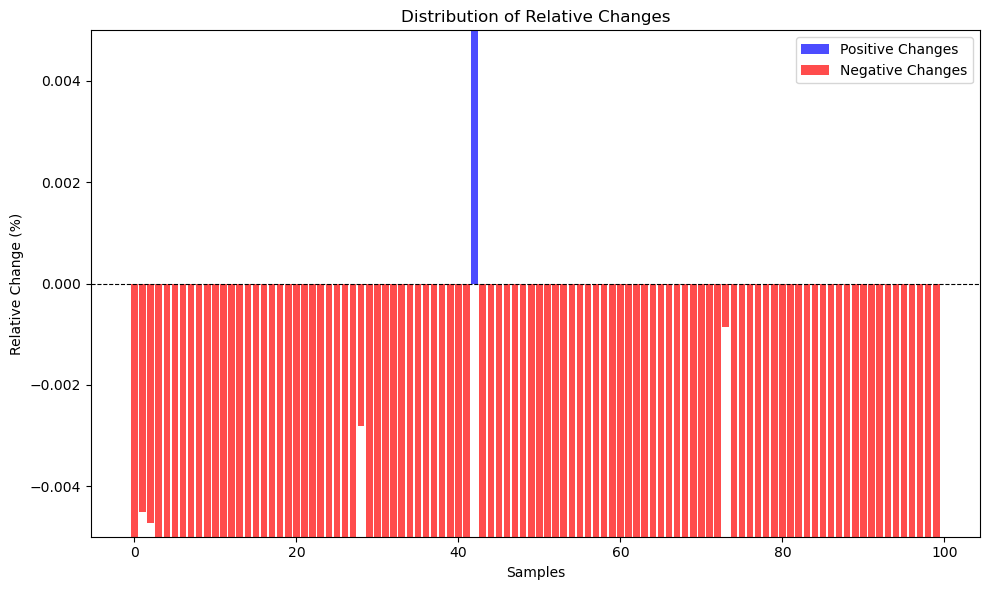


Classification accuracy                             :  0.95
Explanations Contribution Score (ECS) of Full Text  :  0.993
Explanations Contribution Score (ECS) of Top Tokens :  0.34
Overall Relative Change (ORC) positive changes      :  20.022 %
Overall Relative Change (ORC) negative changes      : -66.088 %


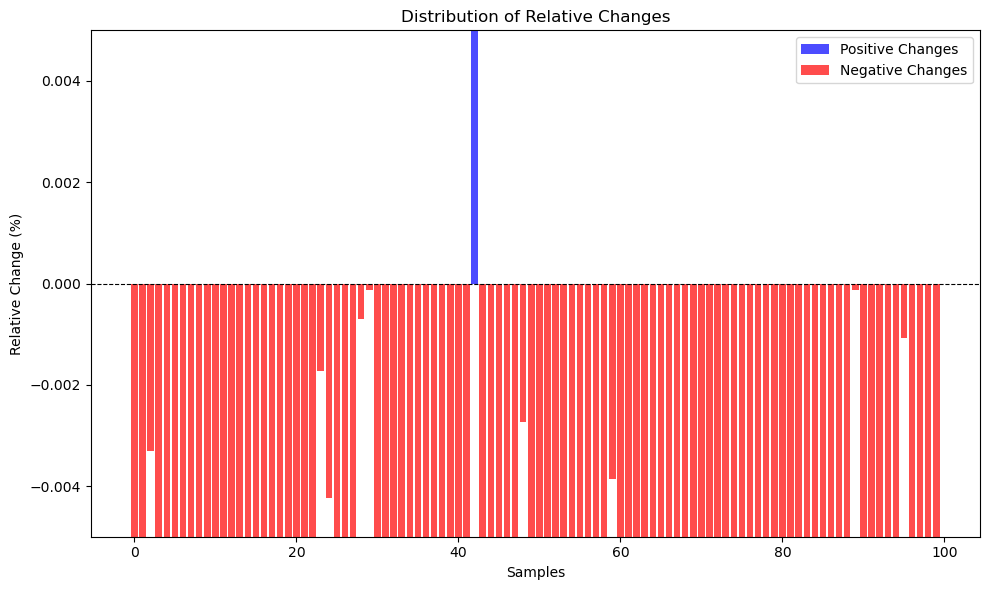


Classification accuracy                             :  0.95
Explanations Contribution Score (ECS) of Full Text  :  0.993
Explanations Contribution Score (ECS) of Top Tokens :  0.326
Overall Relative Change (ORC) positive changes      :  20.609 %
Overall Relative Change (ORC) negative changes      : -67.546 %


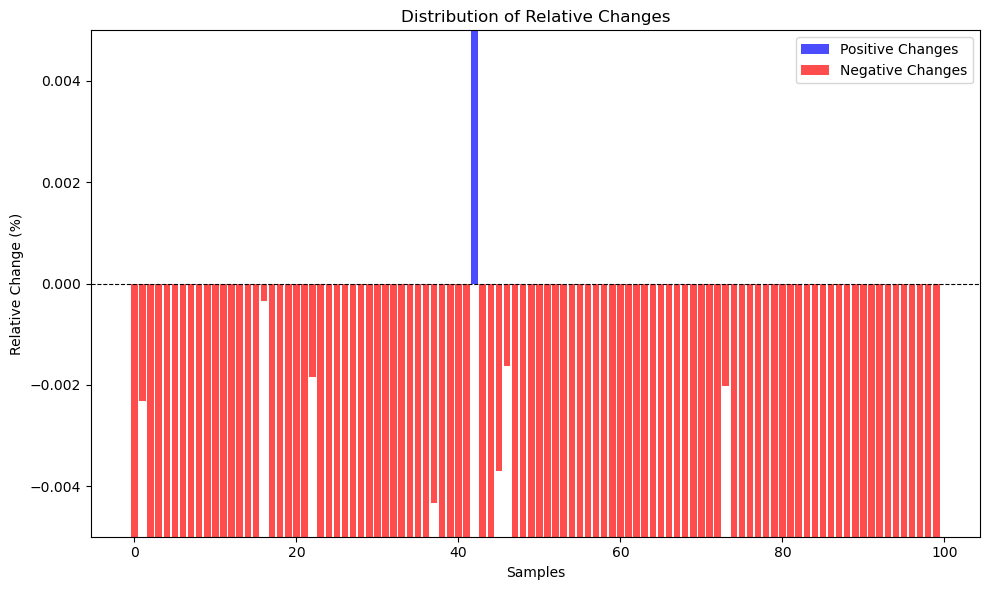

In [43]:
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(tc32_bert_results[0.5][0])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(tc32_bert_results[0.6][0])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(tc32_bert_results[0.7][0])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)

### TurkishBERTweet

#### Inference on Full Text

In [44]:
# Load TurkishBERTweet models

tbt_model_ttc4900, \
tbt_tokenizer_ttc4900, \
tbt_config_ttc4900, \
tbt_pipeline_text_ttc4900, \
tbt_label2id_ttc4900, \
tbt_id2label_ttc4900 = prepare_models(path_tbt_model_ttc4900, device)

tbt_model_tr_news, \
tbt_tokenizer_tr_news, \
tbt_config_tr_news, \
tbt_pipeline_text_tr_news, \
tbt_label2id_tr_news, \
tbt_id2label_tr_news = prepare_models(path_tbt_model_tr_news, device)

tbt_model_interpress, \
tbt_tokenizer_interpress, \
tbt_config_interpress, \
tbt_pipeline_text_interpress, \
tbt_label2id_interpress, \
tbt_id2label_interpress = prepare_models(path_tbt_model_interpress, device)

tbt_model_tc32, \
tbt_tokenizer_tc32, \
tbt_config_tc32, \
tbt_pipeline_text_tc32, \
tbt_label2id_tc32, \
tbt_id2label_tc32 = prepare_models(path_tbt_model_tc32, device)


'turkishbertweet_text_classification_fine_tuned_ttc4900' is loaded.

'turkishbertweet_text_classification_fine_tuned_tr_news' is loaded.

'turkishbertweet_text_classification_fine_tuned_interpress' is loaded.

'turkishbertweet_text_classification_fine_tuned_tc32' is loaded.


In [45]:
path_classification_results = "Data/Classification_Results/TurkishBERTweet/"

with open(path_classification_results + 'tbt_full_text_preds_ttc4900.pkl', 'rb') as file:
    tbt_full_text_preds_ttc4900 = pickle.load(file)

with open(path_classification_results + 'tbt_full_text_preds_tr_news.pkl', 'rb') as file:
    tbt_full_text_preds_tr_news = pickle.load(file)

with open(path_classification_results + 'tbt_full_text_preds_interpress.pkl', 'rb') as file:
    tbt_full_text_preds_interpress = pickle.load(file)

with open(path_classification_results + 'tbt_full_text_preds_tc32.pkl', 'rb') as file:
    tbt_full_text_preds_tc32 = pickle.load(file)

In [46]:
tbt_full_text_preds_ttc4900 = tbt_full_text_preds_ttc4900[:num_samples]
tbt_full_text_preds_tr_news = tbt_full_text_preds_tr_news[:num_samples]
tbt_full_text_preds_interpress = tbt_full_text_preds_interpress[:num_samples]
tbt_full_text_preds_tc32 = tbt_full_text_preds_tc32[:num_samples]

#### TTC4900

In [47]:
ttc4900_tbt_results = {}

for iteration in range(5):
    for threshold in thresholds:
        rand_values_ttc = apply_random(path_rand, ttc4900_test, tbt_model_ttc4900, tbt_tokenizer_ttc4900, 
                                       f"rand_values_ttc_{threshold}_{iteration}_tbt", device, only_load=only_load)
        
        top_tokens_ttc4900 = apply_thresholding(rand_values_ttc, threshold)

        ttc4900_tbt_result = compare_probs(ttc4900_test,
                                            tbt_full_text_preds_ttc4900,
                                            top_tokens_ttc4900,
                                            None,
                                            tbt_model_ttc4900, tbt_tokenizer_ttc4900,
                                            id2label=tbt_id2label_ttc4900,
                                            device=device)

        if threshold not in ttc4900_tbt_results:
            ttc4900_tbt_results[threshold] = []
        ttc4900_tbt_results[threshold].append(ttc4900_tbt_result)

        clear_gpu_memory()

for threshold, dataframes in ttc4900_tbt_results.items():

    base_df = dataframes[0].copy()

    for i, df in enumerate(dataframes):
        base_df[f'Run {i+1} - Pred Prob - Top Tokens'] = df['Pred Prob - Top Tokens']

    top_tokens_means = np.mean([df['Pred Prob - Top Tokens'] for df in dataframes], axis=0)
    top_tokens_stds = np.std([df['Pred Prob - Top Tokens'] for df in dataframes], axis=0)

    base_df['Mean - Pred Prob - Top Tokens'] = top_tokens_means
    base_df['Std - Pred Prob - Top Tokens'] = top_tokens_stds

    ttc4900_tbt_results[threshold] = [base_df]
    
    show(ttc4900_tbt_results[threshold][0], lengthMenu=list(range(10, 200, 30)), dom="lti")

  0%|          | 0/100 [00:00<?, ?it/s]

File 'rand_values_ttc_0.5_0_tbt' saved.
'rand_values_ttc_0.5_0_tbt' file shape: 100


  0%|          | 0/100 [00:00<?, ?it/s]

File 'rand_values_ttc_0.6_0_tbt' saved.
'rand_values_ttc_0.6_0_tbt' file shape: 100


  0%|          | 0/100 [00:00<?, ?it/s]

File 'rand_values_ttc_0.7_0_tbt' saved.
'rand_values_ttc_0.7_0_tbt' file shape: 100


  0%|          | 0/100 [00:00<?, ?it/s]

File 'rand_values_ttc_0.5_1_tbt' saved.
'rand_values_ttc_0.5_1_tbt' file shape: 100


  0%|          | 0/100 [00:00<?, ?it/s]

File 'rand_values_ttc_0.6_1_tbt' saved.
'rand_values_ttc_0.6_1_tbt' file shape: 100


  0%|          | 0/100 [00:00<?, ?it/s]

File 'rand_values_ttc_0.7_1_tbt' saved.
'rand_values_ttc_0.7_1_tbt' file shape: 100


  0%|          | 0/100 [00:00<?, ?it/s]

File 'rand_values_ttc_0.5_2_tbt' saved.
'rand_values_ttc_0.5_2_tbt' file shape: 100


  0%|          | 0/100 [00:00<?, ?it/s]

File 'rand_values_ttc_0.6_2_tbt' saved.
'rand_values_ttc_0.6_2_tbt' file shape: 100


  0%|          | 0/100 [00:00<?, ?it/s]

File 'rand_values_ttc_0.7_2_tbt' saved.
'rand_values_ttc_0.7_2_tbt' file shape: 100


  0%|          | 0/100 [00:00<?, ?it/s]

File 'rand_values_ttc_0.5_3_tbt' saved.
'rand_values_ttc_0.5_3_tbt' file shape: 100


  0%|          | 0/100 [00:00<?, ?it/s]

File 'rand_values_ttc_0.6_3_tbt' saved.
'rand_values_ttc_0.6_3_tbt' file shape: 100


  0%|          | 0/100 [00:00<?, ?it/s]

File 'rand_values_ttc_0.7_3_tbt' saved.
'rand_values_ttc_0.7_3_tbt' file shape: 100


  0%|          | 0/100 [00:00<?, ?it/s]

File 'rand_values_ttc_0.5_4_tbt' saved.
'rand_values_ttc_0.5_4_tbt' file shape: 100


  0%|          | 0/100 [00:00<?, ?it/s]

File 'rand_values_ttc_0.6_4_tbt' saved.
'rand_values_ttc_0.6_4_tbt' file shape: 100


  0%|          | 0/100 [00:00<?, ?it/s]

File 'rand_values_ttc_0.7_4_tbt' saved.
'rand_values_ttc_0.7_4_tbt' file shape: 100



Classification accuracy                             :  0.9
Explanations Contribution Score (ECS) of Full Text  :  0.98
Explanations Contribution Score (ECS) of Top Tokens :  0.898
Overall Relative Change (ORC) positive changes      :  0.911 %
Overall Relative Change (ORC) negative changes      : -13.928 %


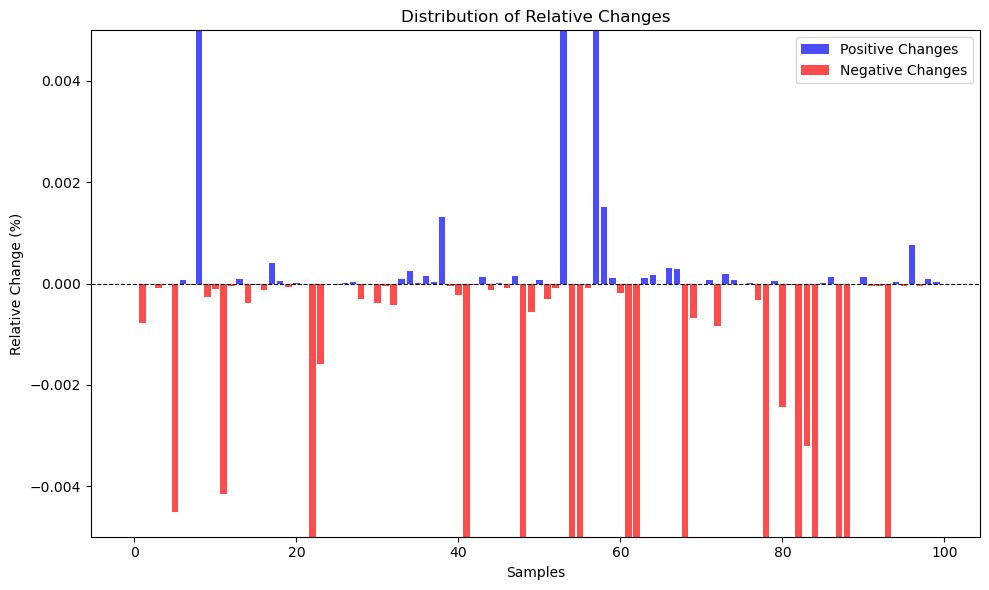


Classification accuracy                             :  0.9
Explanations Contribution Score (ECS) of Full Text  :  0.98
Explanations Contribution Score (ECS) of Top Tokens :  0.851
Overall Relative Change (ORC) positive changes      :  1.493 %
Overall Relative Change (ORC) negative changes      : -23.017 %


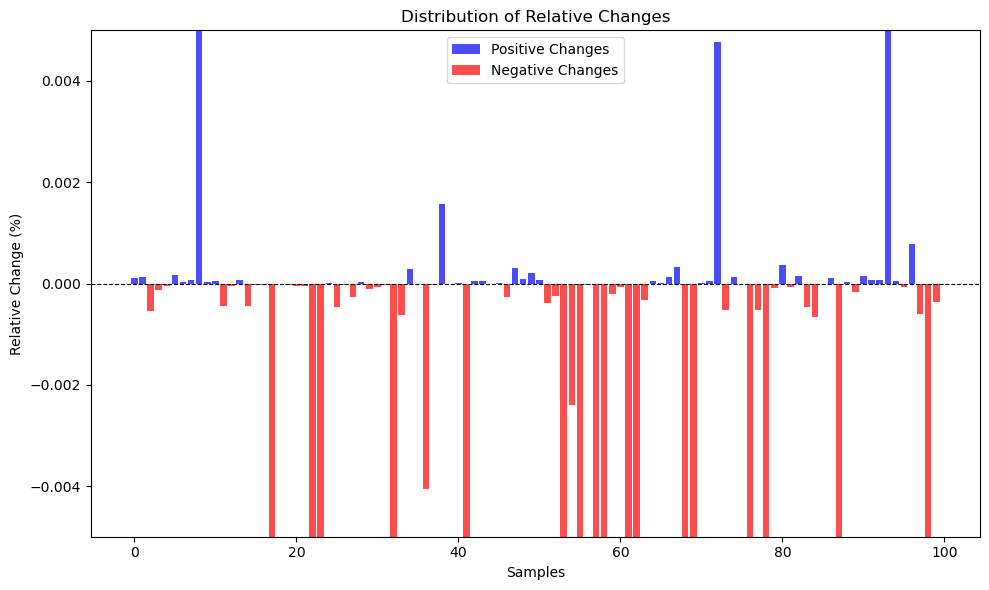


Classification accuracy                             :  0.9
Explanations Contribution Score (ECS) of Full Text  :  0.98
Explanations Contribution Score (ECS) of Top Tokens :  0.884
Overall Relative Change (ORC) positive changes      :  0.87 %
Overall Relative Change (ORC) negative changes      : -16.14 %


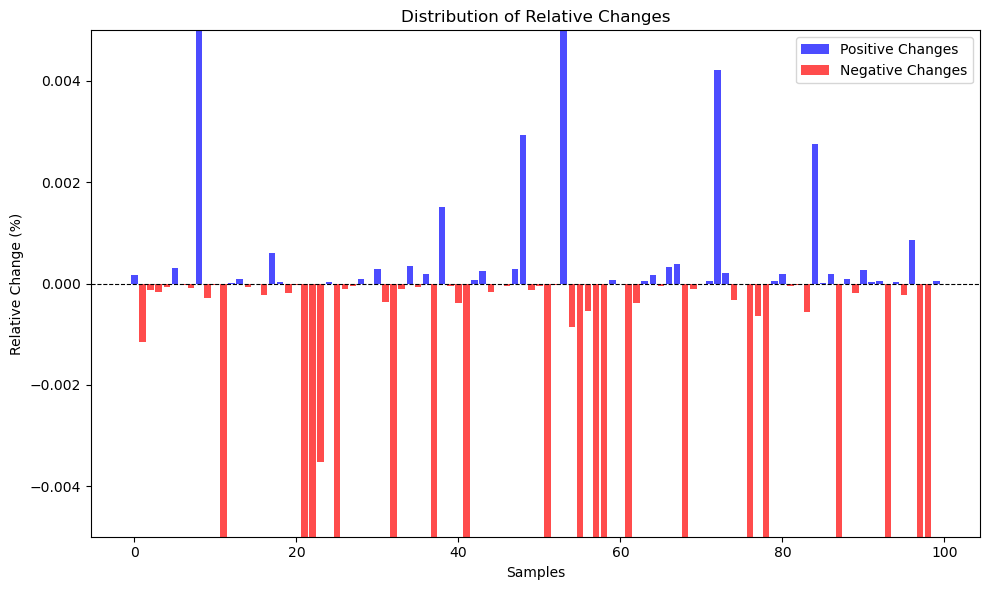

In [48]:
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(ttc4900_tbt_results[0.5][0])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(ttc4900_tbt_results[0.6][0])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(ttc4900_tbt_results[0.7][0])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)

#### TR News

In [49]:
tr_news_tbt_results = {}

for iteration in range(5):
    for threshold in thresholds:

        rand_values_tr_news = apply_random(path_rand, tr_news_test, tbt_model_tr_news, tbt_tokenizer_tr_news, 
                                           f"rand_values_tr_news_{threshold}_{iteration}_tbt", device, only_load=only_load)
        
        top_tokens_tr_news = apply_thresholding(rand_values_tr_news, threshold)
    
        tr_news_tbt_result = compare_probs(tr_news_test,
                                            tbt_full_text_preds_tr_news,
                                            top_tokens_tr_news,
                                            None,
                                            tbt_model_tr_news, tbt_tokenizer_tr_news,
                                            id2label=tbt_id2label_tr_news,
                                            device=device)

        if threshold not in tr_news_tbt_results:
            tr_news_tbt_results[threshold] = []
        tr_news_tbt_results[threshold].append(tr_news_tbt_result)
        
        clear_gpu_memory()

for threshold, dataframes in tr_news_tbt_results.items():

    base_df = dataframes[0].copy()

    for i, df in enumerate(dataframes):
        base_df[f'Run {i+1} - Pred Prob - Top Tokens'] = df['Pred Prob - Top Tokens']

    top_tokens_means = np.mean([df['Pred Prob - Top Tokens'] for df in dataframes], axis=0)
    top_tokens_stds = np.std([df['Pred Prob - Top Tokens'] for df in dataframes], axis=0)

    base_df['Mean - Pred Prob - Top Tokens'] = top_tokens_means
    base_df['Std - Pred Prob - Top Tokens'] = top_tokens_stds

    tr_news_tbt_results[threshold] = [base_df]
    
    show(tr_news_tbt_results[threshold][0], lengthMenu=list(range(10, 200, 30)), dom="lti")

  0%|          | 0/100 [00:00<?, ?it/s]

File 'rand_values_tr_news_0.5_0_tbt' saved.
'rand_values_tr_news_0.5_0_tbt' file shape: 100


  0%|          | 0/100 [00:00<?, ?it/s]

File 'rand_values_tr_news_0.6_0_tbt' saved.
'rand_values_tr_news_0.6_0_tbt' file shape: 100


  0%|          | 0/100 [00:00<?, ?it/s]

File 'rand_values_tr_news_0.7_0_tbt' saved.
'rand_values_tr_news_0.7_0_tbt' file shape: 100


  0%|          | 0/100 [00:00<?, ?it/s]

File 'rand_values_tr_news_0.5_1_tbt' saved.
'rand_values_tr_news_0.5_1_tbt' file shape: 100


  0%|          | 0/100 [00:00<?, ?it/s]

File 'rand_values_tr_news_0.6_1_tbt' saved.
'rand_values_tr_news_0.6_1_tbt' file shape: 100


  0%|          | 0/100 [00:00<?, ?it/s]

File 'rand_values_tr_news_0.7_1_tbt' saved.
'rand_values_tr_news_0.7_1_tbt' file shape: 100


  0%|          | 0/100 [00:00<?, ?it/s]

File 'rand_values_tr_news_0.5_2_tbt' saved.
'rand_values_tr_news_0.5_2_tbt' file shape: 100


  0%|          | 0/100 [00:00<?, ?it/s]

File 'rand_values_tr_news_0.6_2_tbt' saved.
'rand_values_tr_news_0.6_2_tbt' file shape: 100


  0%|          | 0/100 [00:00<?, ?it/s]

File 'rand_values_tr_news_0.7_2_tbt' saved.
'rand_values_tr_news_0.7_2_tbt' file shape: 100


  0%|          | 0/100 [00:00<?, ?it/s]

File 'rand_values_tr_news_0.5_3_tbt' saved.
'rand_values_tr_news_0.5_3_tbt' file shape: 100


  0%|          | 0/100 [00:00<?, ?it/s]

File 'rand_values_tr_news_0.6_3_tbt' saved.
'rand_values_tr_news_0.6_3_tbt' file shape: 100


  0%|          | 0/100 [00:00<?, ?it/s]

File 'rand_values_tr_news_0.7_3_tbt' saved.
'rand_values_tr_news_0.7_3_tbt' file shape: 100


  0%|          | 0/100 [00:00<?, ?it/s]

File 'rand_values_tr_news_0.5_4_tbt' saved.
'rand_values_tr_news_0.5_4_tbt' file shape: 100


  0%|          | 0/100 [00:00<?, ?it/s]

File 'rand_values_tr_news_0.6_4_tbt' saved.
'rand_values_tr_news_0.6_4_tbt' file shape: 100


  0%|          | 0/100 [00:00<?, ?it/s]

File 'rand_values_tr_news_0.7_4_tbt' saved.
'rand_values_tr_news_0.7_4_tbt' file shape: 100



Classification accuracy                             :  0.7
Explanations Contribution Score (ECS) of Full Text  :  0.809
Explanations Contribution Score (ECS) of Top Tokens :  0.651
Overall Relative Change (ORC) positive changes      :  4.149 %
Overall Relative Change (ORC) negative changes      : -25.244 %


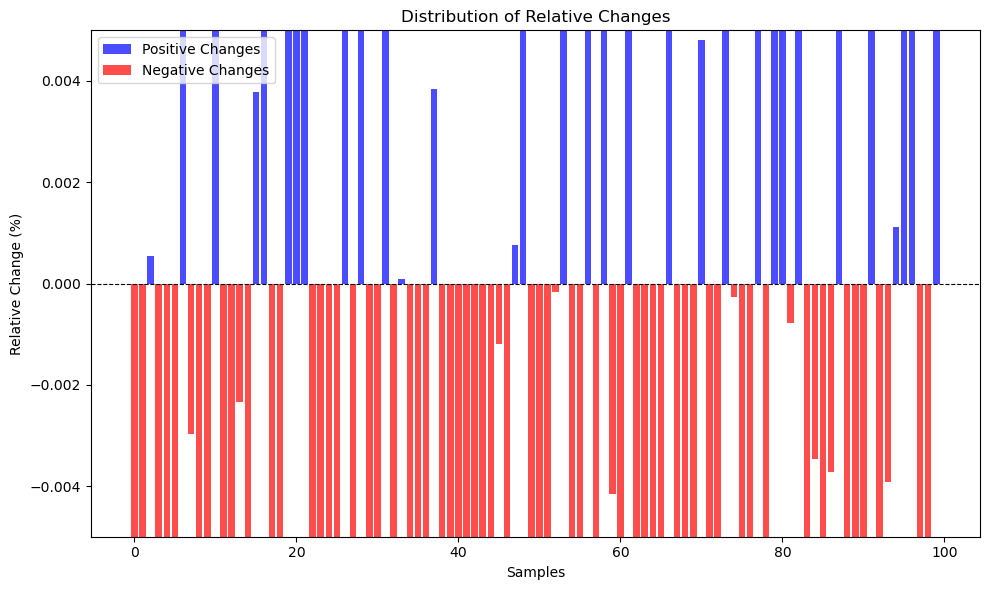


Classification accuracy                             :  0.7
Explanations Contribution Score (ECS) of Full Text  :  0.809
Explanations Contribution Score (ECS) of Top Tokens :  0.621
Overall Relative Change (ORC) positive changes      :  5.45 %
Overall Relative Change (ORC) negative changes      : -28.314 %


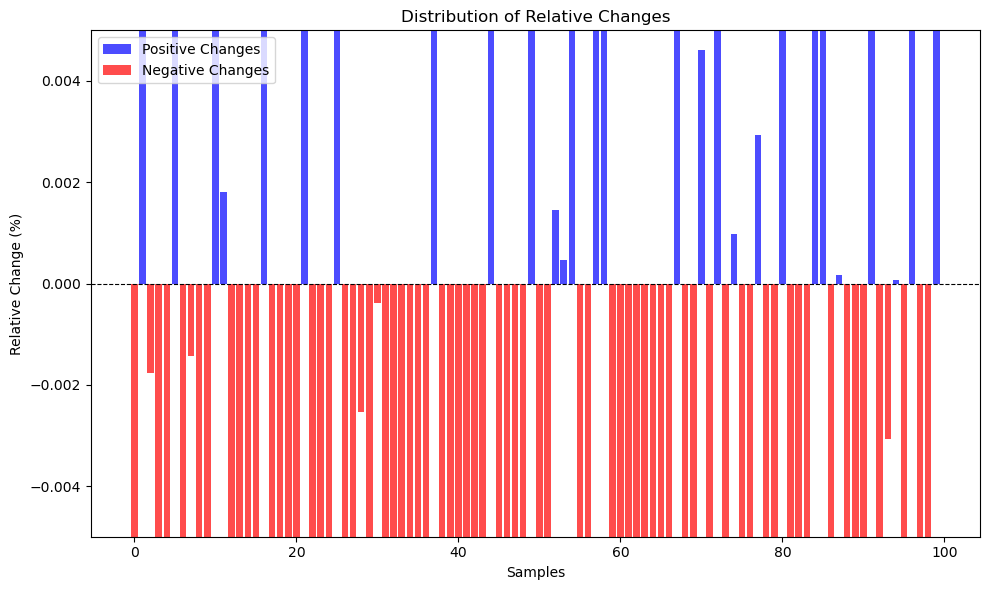


Classification accuracy                             :  0.7
Explanations Contribution Score (ECS) of Full Text  :  0.809
Explanations Contribution Score (ECS) of Top Tokens :  0.573
Overall Relative Change (ORC) positive changes      :  4.317 %
Overall Relative Change (ORC) negative changes      : -34.974 %


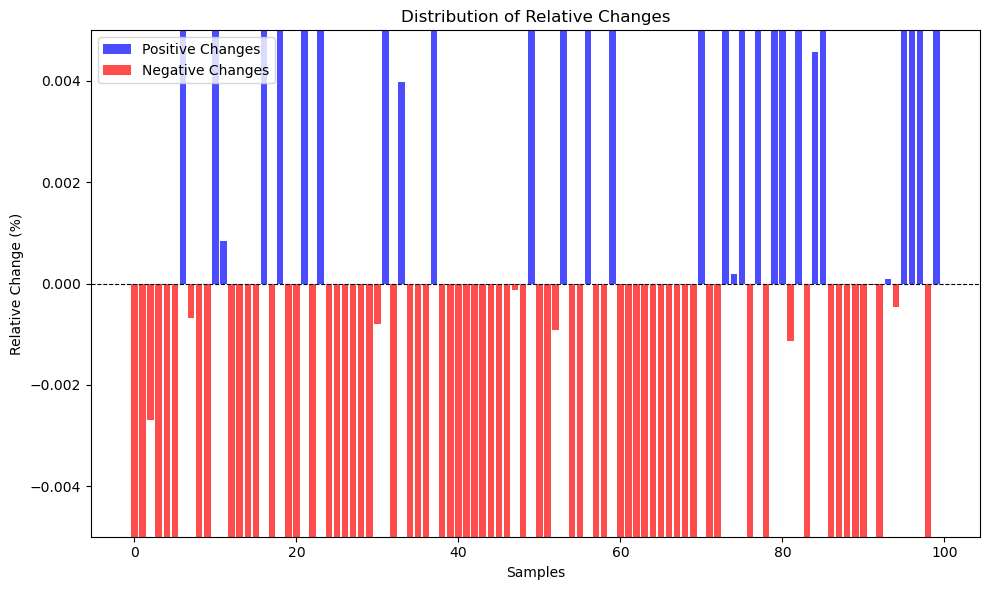

In [50]:
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(tr_news_tbt_results[0.5][0])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(tr_news_tbt_results[0.6][0])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(tr_news_tbt_results[0.7][0])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)

#### Interpress

In [51]:
interpress_tbt_results = {}

for iteration in range(5):
    for threshold in thresholds:

        rand_values_interpress = apply_random(path_rand, interpress_test, tbt_model_interpress, tbt_tokenizer_interpress, 
                                              f"rand_values_interpress_{threshold}_{iteration}_tbt", device, only_load=only_load)
        
        top_tokens_interpress = apply_thresholding(rand_values_interpress, threshold)
    
        interpress_tbt_result = compare_probs(interpress_test,
                                               tbt_full_text_preds_interpress,
                                               top_tokens_interpress,
                                               None,
                                               tbt_model_interpress, tbt_tokenizer_interpress,
                                               id2label=tbt_id2label_interpress,
                                               device=device)

        if threshold not in interpress_tbt_results:
            interpress_tbt_results[threshold] = []
        interpress_tbt_results[threshold].append(interpress_tbt_result)
        
        clear_gpu_memory()

for threshold, dataframes in interpress_tbt_results.items():

    base_df = dataframes[0].copy()

    for i, df in enumerate(dataframes):
        base_df[f'Run {i+1} - Pred Prob - Top Tokens'] = df['Pred Prob - Top Tokens']

    top_tokens_means = np.mean([df['Pred Prob - Top Tokens'] for df in dataframes], axis=0)
    top_tokens_stds = np.std([df['Pred Prob - Top Tokens'] for df in dataframes], axis=0)

    base_df['Mean - Pred Prob - Top Tokens'] = top_tokens_means
    base_df['Std - Pred Prob - Top Tokens'] = top_tokens_stds

    interpress_tbt_results[threshold] = [base_df]
    
    show(interpress_tbt_results[threshold][0], lengthMenu=list(range(10, 200, 30)), dom="lti")

  0%|          | 0/100 [00:00<?, ?it/s]

File 'rand_values_interpress_0.5_0_tbt' saved.
'rand_values_interpress_0.5_0_tbt' file shape: 100


  0%|          | 0/100 [00:00<?, ?it/s]

File 'rand_values_interpress_0.6_0_tbt' saved.
'rand_values_interpress_0.6_0_tbt' file shape: 100


  0%|          | 0/100 [00:00<?, ?it/s]

File 'rand_values_interpress_0.7_0_tbt' saved.
'rand_values_interpress_0.7_0_tbt' file shape: 100


  0%|          | 0/100 [00:00<?, ?it/s]

File 'rand_values_interpress_0.5_1_tbt' saved.
'rand_values_interpress_0.5_1_tbt' file shape: 100


  0%|          | 0/100 [00:00<?, ?it/s]

File 'rand_values_interpress_0.6_1_tbt' saved.
'rand_values_interpress_0.6_1_tbt' file shape: 100


  0%|          | 0/100 [00:00<?, ?it/s]

File 'rand_values_interpress_0.7_1_tbt' saved.
'rand_values_interpress_0.7_1_tbt' file shape: 100


  0%|          | 0/100 [00:00<?, ?it/s]

File 'rand_values_interpress_0.5_2_tbt' saved.
'rand_values_interpress_0.5_2_tbt' file shape: 100


  0%|          | 0/100 [00:00<?, ?it/s]

File 'rand_values_interpress_0.6_2_tbt' saved.
'rand_values_interpress_0.6_2_tbt' file shape: 100


  0%|          | 0/100 [00:00<?, ?it/s]

File 'rand_values_interpress_0.7_2_tbt' saved.
'rand_values_interpress_0.7_2_tbt' file shape: 100


  0%|          | 0/100 [00:00<?, ?it/s]

File 'rand_values_interpress_0.5_3_tbt' saved.
'rand_values_interpress_0.5_3_tbt' file shape: 100


  0%|          | 0/100 [00:00<?, ?it/s]

File 'rand_values_interpress_0.6_3_tbt' saved.
'rand_values_interpress_0.6_3_tbt' file shape: 100


  0%|          | 0/100 [00:00<?, ?it/s]

File 'rand_values_interpress_0.7_3_tbt' saved.
'rand_values_interpress_0.7_3_tbt' file shape: 100


  0%|          | 0/100 [00:00<?, ?it/s]

File 'rand_values_interpress_0.5_4_tbt' saved.
'rand_values_interpress_0.5_4_tbt' file shape: 100


  0%|          | 0/100 [00:00<?, ?it/s]

File 'rand_values_interpress_0.6_4_tbt' saved.
'rand_values_interpress_0.6_4_tbt' file shape: 100


  0%|          | 0/100 [00:00<?, ?it/s]

File 'rand_values_interpress_0.7_4_tbt' saved.
'rand_values_interpress_0.7_4_tbt' file shape: 100



Classification accuracy                             :  0.75
Explanations Contribution Score (ECS) of Full Text  :  0.865
Explanations Contribution Score (ECS) of Top Tokens :  0.652
Overall Relative Change (ORC) positive changes      :  7.261 %
Overall Relative Change (ORC) negative changes      : -32.96 %


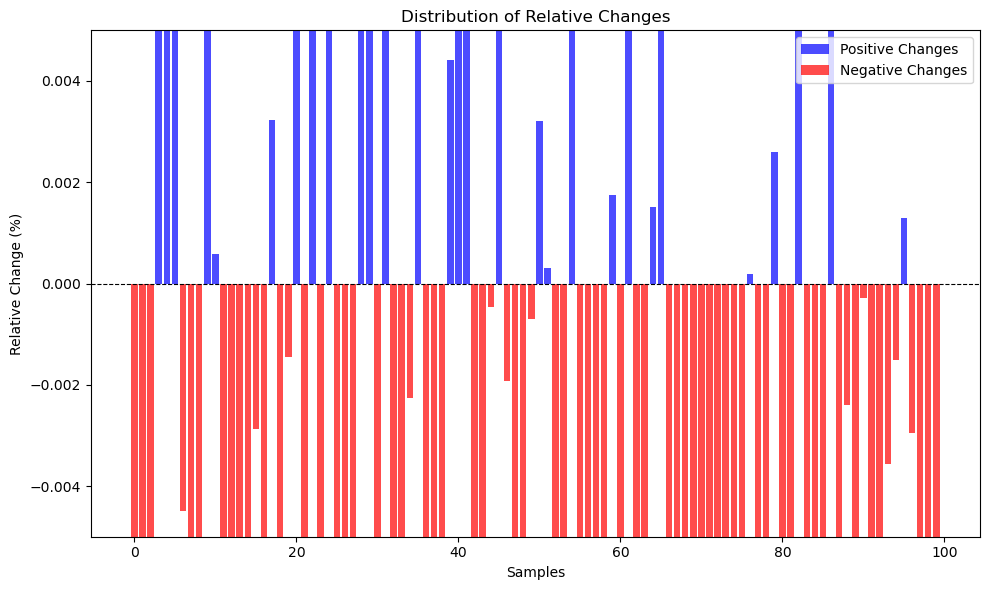


Classification accuracy                             :  0.75
Explanations Contribution Score (ECS) of Full Text  :  0.865
Explanations Contribution Score (ECS) of Top Tokens :  0.594
Overall Relative Change (ORC) positive changes      :  10.461 %
Overall Relative Change (ORC) negative changes      : -46.476 %


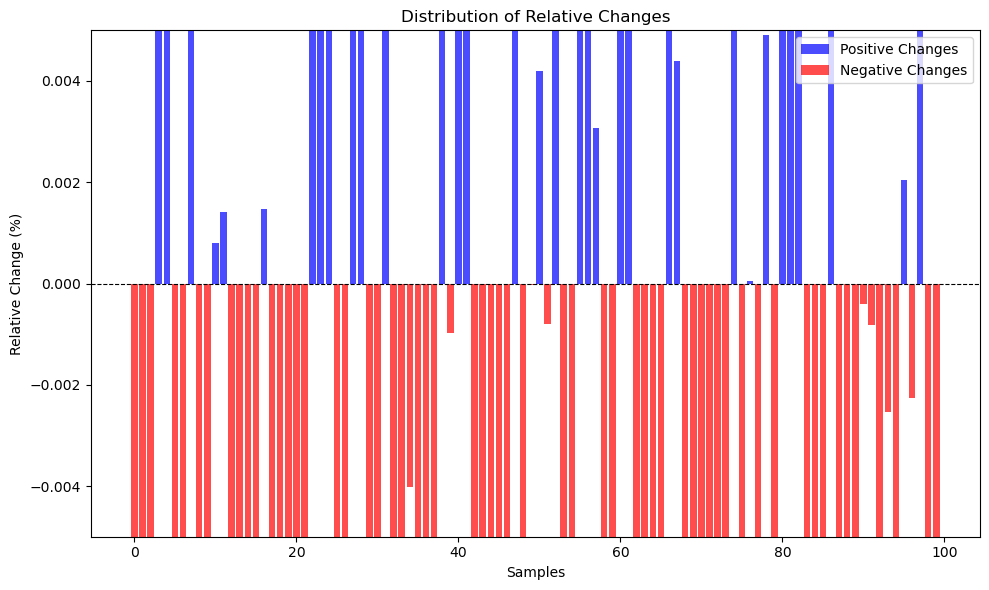


Classification accuracy                             :  0.75
Explanations Contribution Score (ECS) of Full Text  :  0.865
Explanations Contribution Score (ECS) of Top Tokens :  0.603
Overall Relative Change (ORC) positive changes      :  8.262 %
Overall Relative Change (ORC) negative changes      : -37.781 %


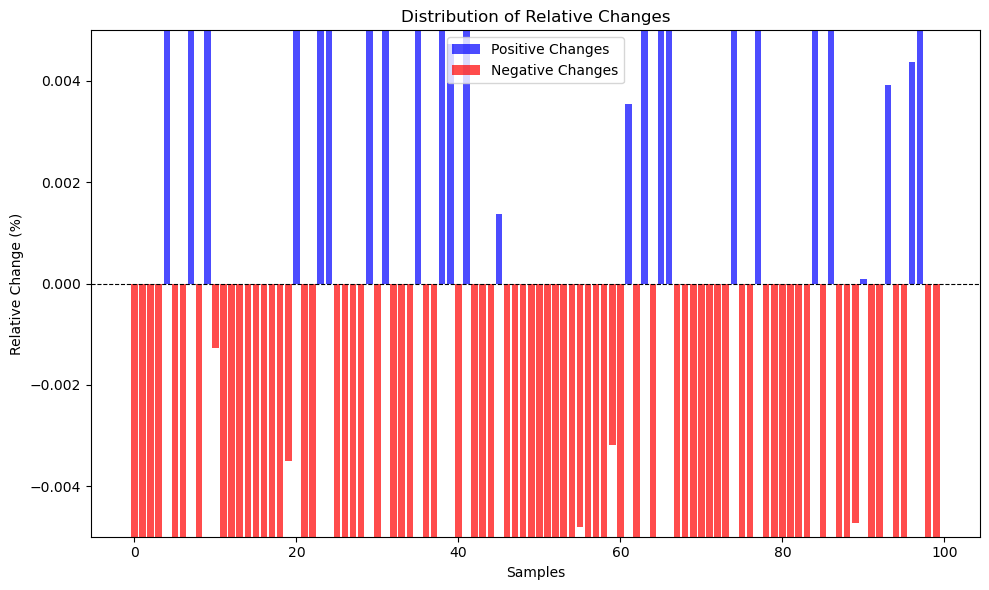

In [52]:
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(interpress_tbt_results[0.5][0])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(interpress_tbt_results[0.6][0])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(interpress_tbt_results[0.7][0])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)

#### TC32

In [53]:
tc32_tbt_results = {}

for iteration in range(5):
    for threshold in thresholds:

        rand_values_tc32 = apply_random(path_rand, tc32_test, tbt_model_tc32, tbt_tokenizer_tc32, 
                                              f"rand_values_tc32_{threshold}_{iteration}_tbt", device, only_load=only_load)
        
        top_tokens_tc32 = apply_thresholding(rand_values_tc32, threshold)
    
        tc32_tbt_result = compare_probs(tc32_test,
                                               tbt_full_text_preds_tc32,
                                               top_tokens_tc32,
                                               None,
                                               tbt_model_tc32, tbt_tokenizer_tc32,
                                               id2label=tbt_id2label_tc32,
                                               device=device)

        if threshold not in tc32_tbt_results:
            tc32_tbt_results[threshold] = []
        tc32_tbt_results[threshold].append(tc32_tbt_result)
        
        clear_gpu_memory()

for threshold, dataframes in tc32_tbt_results.items():

    base_df = dataframes[0].copy()

    for i, df in enumerate(dataframes):
        base_df[f'Run {i+1} - Pred Prob - Top Tokens'] = df['Pred Prob - Top Tokens']

    top_tokens_means = np.mean([df['Pred Prob - Top Tokens'] for df in dataframes], axis=0)
    top_tokens_stds = np.std([df['Pred Prob - Top Tokens'] for df in dataframes], axis=0)

    base_df['Mean - Pred Prob - Top Tokens'] = top_tokens_means
    base_df['Std - Pred Prob - Top Tokens'] = top_tokens_stds

    tc32_tbt_results[threshold] = [base_df]
    
    show(tc32_tbt_results[threshold][0], lengthMenu=list(range(10, 200, 30)), dom="lti")

  0%|          | 0/100 [00:00<?, ?it/s]

File 'rand_values_tc32_0.5_0_tbt' saved.
'rand_values_tc32_0.5_0_tbt' file shape: 100


  0%|          | 0/100 [00:00<?, ?it/s]

File 'rand_values_tc32_0.6_0_tbt' saved.
'rand_values_tc32_0.6_0_tbt' file shape: 100


  0%|          | 0/100 [00:00<?, ?it/s]

File 'rand_values_tc32_0.7_0_tbt' saved.
'rand_values_tc32_0.7_0_tbt' file shape: 100


  0%|          | 0/100 [00:00<?, ?it/s]

File 'rand_values_tc32_0.5_1_tbt' saved.
'rand_values_tc32_0.5_1_tbt' file shape: 100


  0%|          | 0/100 [00:00<?, ?it/s]

File 'rand_values_tc32_0.6_1_tbt' saved.
'rand_values_tc32_0.6_1_tbt' file shape: 100


  0%|          | 0/100 [00:00<?, ?it/s]

File 'rand_values_tc32_0.7_1_tbt' saved.
'rand_values_tc32_0.7_1_tbt' file shape: 100


  0%|          | 0/100 [00:00<?, ?it/s]

File 'rand_values_tc32_0.5_2_tbt' saved.
'rand_values_tc32_0.5_2_tbt' file shape: 100


  0%|          | 0/100 [00:00<?, ?it/s]

File 'rand_values_tc32_0.6_2_tbt' saved.
'rand_values_tc32_0.6_2_tbt' file shape: 100


  0%|          | 0/100 [00:00<?, ?it/s]

File 'rand_values_tc32_0.7_2_tbt' saved.
'rand_values_tc32_0.7_2_tbt' file shape: 100


  0%|          | 0/100 [00:00<?, ?it/s]

File 'rand_values_tc32_0.5_3_tbt' saved.
'rand_values_tc32_0.5_3_tbt' file shape: 100


  0%|          | 0/100 [00:00<?, ?it/s]

File 'rand_values_tc32_0.6_3_tbt' saved.
'rand_values_tc32_0.6_3_tbt' file shape: 100


  0%|          | 0/100 [00:00<?, ?it/s]

File 'rand_values_tc32_0.7_3_tbt' saved.
'rand_values_tc32_0.7_3_tbt' file shape: 100


  0%|          | 0/100 [00:00<?, ?it/s]

File 'rand_values_tc32_0.5_4_tbt' saved.
'rand_values_tc32_0.5_4_tbt' file shape: 100


  0%|          | 0/100 [00:00<?, ?it/s]

File 'rand_values_tc32_0.6_4_tbt' saved.
'rand_values_tc32_0.6_4_tbt' file shape: 100


  0%|          | 0/100 [00:00<?, ?it/s]

File 'rand_values_tc32_0.7_4_tbt' saved.
'rand_values_tc32_0.7_4_tbt' file shape: 100



Classification accuracy                             :  0.89
Explanations Contribution Score (ECS) of Full Text  :  0.964
Explanations Contribution Score (ECS) of Top Tokens :  0.341
Overall Relative Change (ORC) positive changes      :  2.394 %
Overall Relative Change (ORC) negative changes      : -64.963 %


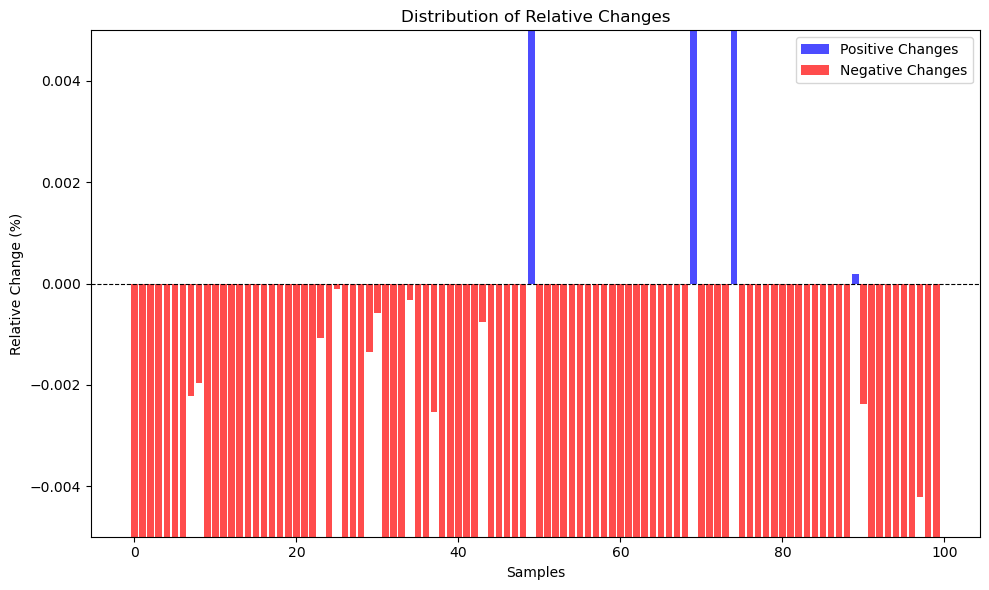


Classification accuracy                             :  0.89
Explanations Contribution Score (ECS) of Full Text  :  0.964
Explanations Contribution Score (ECS) of Top Tokens :  0.32
Overall Relative Change (ORC) positive changes      :  1.92 %
Overall Relative Change (ORC) negative changes      : -69.358 %


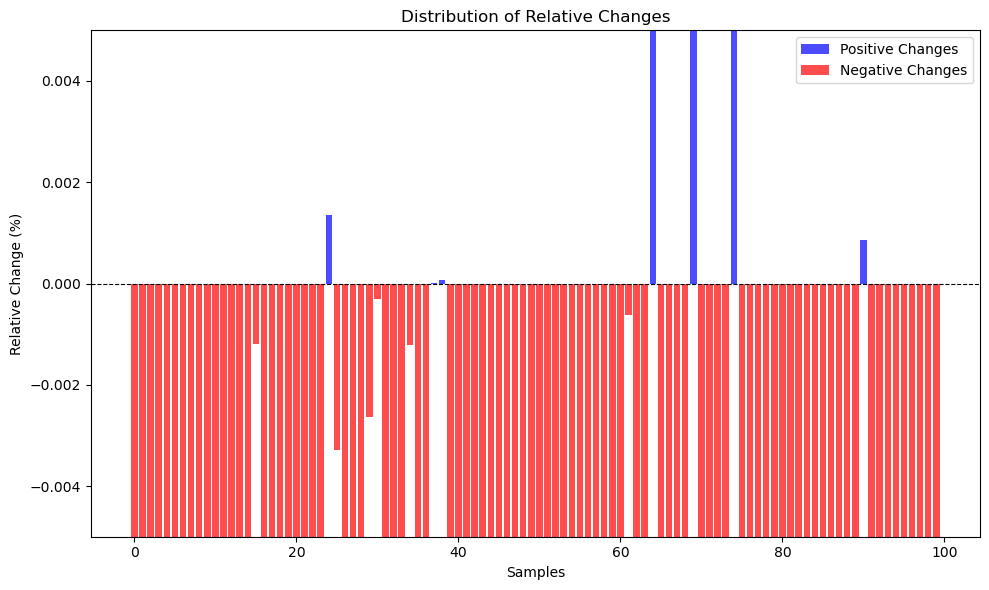


Classification accuracy                             :  0.89
Explanations Contribution Score (ECS) of Full Text  :  0.964
Explanations Contribution Score (ECS) of Top Tokens :  0.273
Overall Relative Change (ORC) positive changes      :  0.375 %
Overall Relative Change (ORC) negative changes      : -70.551 %


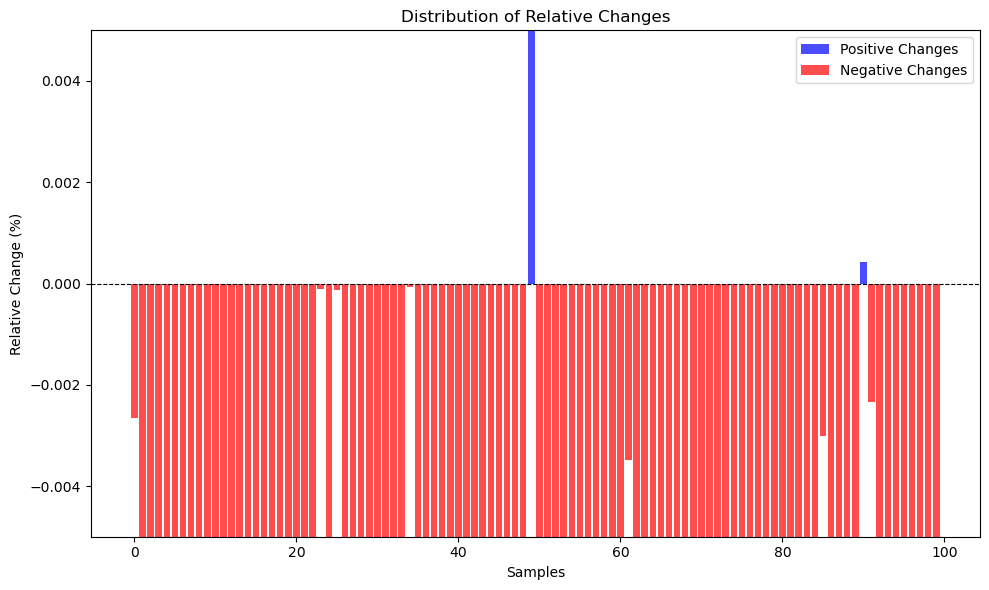

In [54]:
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(tc32_tbt_results[0.5][0])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(tc32_tbt_results[0.6][0])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(tc32_tbt_results[0.7][0])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)

## Final Results

In [55]:
all_exp_results

,Cl Acc,ECS FT,ECS TT,ORC (+),ORC (-)
0,0.88,0.972,0.840,1.097,-17.284
1,0.88,0.972,0.860,2.509,-14.792
2,0.88,0.972,0.818,4.767,-19.506
3,0.75,0.839,0.612,6.301,-26.309
4,0.75,0.839,0.597,9.189,-28.314
5,0.75,0.839,0.556,4.756,-34.167
6,0.84,0.934,0.779,2.942,-20.672
7,0.84,0.934,0.717,5.195,-27.603
8,0.84,0.934,0.741,5.018,-25.805
9,0.95,0.993,0.407,20.418,-59.381


In [56]:
excel_file = path_reports + 'all_exp_results.xlsx'

with pd.ExcelWriter(excel_file, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
    all_exp_results.to_excel(writer, sheet_name='Random', index=False)